# Collaboration Platform Analysis Case Study

## By Giang (GiGi) Nguyen

This is a case study on collaboration tool company that helps teams or individuals organize, track, and manage their work.


The data has the following two files:
 
A user file ("takehome_users") with data on 12,000 users who signed up for the product in the last two years. This table includes:

- name: the user's name

- object_id: the user's id

- email: email address

- email_domain: domain of email address, e.g. gmail.com

- creation_source: how they signed up for the product. This takes on one of 5 values:

    - PERSONAL_PROJECTS: invited to join another user's personal workspace

    - GUEST_INVITE: invited to an organization as a guest (limited permissions)

    - ORG_INVITE: invited to an organization (as a full member)

    - SIGNUP: signed up via main website

    - SIGNUP_GOOGLE_AUTH: signed up using Google

- Authentication (using a Google email account for their login id)

- creation_time: when they created their account

- last_session_creation_time: unix timestamp of last login

- opted_in_to_mailing_list: whether they have opted into receiving marketing emails

- enabled_for_marketing_drip: whether they are on the regular marketing email drip

- org_id: the organization (group of users) they belong to

- invited_by_user_id: which user invited them to join (if applicable).
 
A usage summary file ("takehome_user_engagement") that has a row for each day that a user logged into the product.

## Case Study

For this case study, I will look into user adoption. The company defines an "adopted user" as a user who has logged into the product on three separate days in at least one seven-day period. I believe that adopted users are more likely to be successful at using the collaboration tool in the long term than those that are not adopted, so I want to know what things are likely indicators of future adoption. With this in mind, I will identify which factors predict user adoption.

My work will focus on improving this experience to increase adoption, so I'd like to know how successful the collaboration tool currently is at getting different types of users to adopt.

For the privacy of the data, I will only make the dataset visible in this Jupyter Notebook without posting the actual data on github.


# Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from pandas import DataFrame, Series
import datetime as dt
import time
import pytz

sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
sns.set_palette("husl")


In [4]:
#Prophet time-series analysis package
from fbprophet import Prophet
import datetime
from datetime import datetime

In [5]:
#Address imbalance data
from imblearn.over_sampling import SMOTE

In [6]:
#Preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

#Gridsearch for hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [7]:
#Feature selection
from sklearn import datasets
from sklearn.feature_selection import RFE


In [8]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor

In [9]:
#XGBoost
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot

In [10]:
#logistics regression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import statsmodels.api as sm

#confusion matrix
from sklearn.metrics import confusion_matrix


In [11]:
#ROC curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# Load Data

In [12]:
user_cnt = pd.read_csv('takehome_user_engagement-intern.csv',encoding = "ISO-8859-1",parse_dates=['time_stamp'])
user_eng = pd.read_csv('takehome_users-intern.csv',encoding = "ISO-8859-1",parse_dates=['creation_time'])

In [13]:
#Info about the takehome_user_engagement-intern.csv data
user_cnt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null datetime64[ns]
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


In [14]:
#Info about the takehome_users-intern.csv data
user_eng.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
email_domain                  12000 non-null object
dtypes: datetime64[ns](1), float64(2), int64(4), object(4)
memory usage: 1.0+ MB


In [15]:
#Take a brief look at first 5 rows of the dataframe user_cnt
user_cnt.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [16]:
#Take a brief look at first 5 rows of the dataframe user_eng
user_eng.sort_values(by='creation_time').head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,email_domain
3860,3861,2012-05-31 00:43:27,Jensen Stine,StineAJensen@yahoo.com,ORG_INVITE,1.338684e+09,0,0,115,3861.0,yahoo.com
11429,11430,2012-05-31 01:42:31,Wood Levi,LeviWood@hotmail.com,ORG_INVITE,1.338515e+09,0,0,239,5677.0,hotmail.com
7169,7170,2012-05-31 06:23:51,Cavalcanti Leonardo,LeonardoPereiraCavalcanti@hotmail.com,ORG_INVITE,1.345444e+09,0,0,145,7170.0,hotmail.com
10011,10012,2012-05-31 08:20:06,Spikes Danille,DanilleJSpikes@hotmail.com,ORG_INVITE,1.338452e+09,0,1,225,7104.0,hotmail.com
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0,0,6,NaN,iuxiw.com


# Data Cleaning and Manipulation

### Filter out Adopted Users

In [17]:
#user that have at least 3 logs regardless of the time frame
user_cnt_3_log = user_cnt.groupby('user_id').filter(lambda x: len(x) >= 3).sort_values(by=['user_id','time_stamp'])
user_cnt_3_log.head()

,time_stamp,user_id,visited
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1
5,2013-12-31 03:45:04,2,1


In [18]:
#write the function to filter out only adopted users - users logged in at least 3 separate days within 1 7-day period
def adopted_user(duration, logs, user_ids):
   
    # duration: we will put duration of 7 days in here
    # logs: we will put the numbers of logs in here - 3 logs
    # user_ids: unique user id

    # adopted: boolean value that returns whether or not the user have at least 3 logins within a 7-day period

    unique_users = len(user_ids.index) #loop through the user_id
    day = 0
    user_log = 1
    adopted = False

    while user_log < logs: #keep iterate if the users loggin is smaller than our 3-log cap
        
        if (day+2) < unique_users: #this keep iterate for each unique user
            
            #this statement guarantee the next row is within 7 days and the previous row is within 1 day
            if (user_ids['time_stamp'].iloc[day + 1] - user_ids['time_stamp'].iloc[day]) <= pd.Timedelta(days=duration) \
            and (user_ids['time_stamp'].iloc[day + 1] - user_ids['time_stamp'].iloc[day]) > pd.Timedelta(days=1) :
                user_log += 1 #log user activity when the users loggin in 2 times
                new_timeframe = (user_ids['time_stamp'].iloc[day + 1] - user_ids['time_stamp'].iloc[day])
                
                #this statement guarantee the next row is within the number of days above and the previous row is within 1 day
                if (user_ids['time_stamp'].iloc[day + 2] - user_ids['time_stamp'].iloc[day + 1]) <= new_timeframe \
                and (user_ids['time_stamp'].iloc[day + 2] - user_ids['time_stamp'].iloc[day + 1]) > pd.Timedelta(days=1):
                    user_log += 1 #if they log in, user logs will = 3 then we exite the loop
                    adopted = True #return true to keep the user that have at least 3 logs
                    
                else: 
                    day += 1
                    user_log = 1
                    
            else:
                day += 1
                user_log = 1
                
        else:
            user_log = logs 
            
    return adopted


In [19]:
# Group data by user_id to apply the function
user_id_group = user_cnt_3_log.groupby('user_id')

In [20]:
#apply the function to filter the adopted users
adopted_users = user_id_group.filter(lambda x: adopted_user(duration=7, logs=3, user_ids=x) ==True)

In [21]:
#take a quick look at first 5 rows
adopted_users.head()

,time_stamp,user_id,visited
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1
5,2013-12-31 03:45:04,2,1


In [22]:
#now we want to keep the list of unique id to join into the user_eng dataframe
adopted_user_id = pd.DataFrame(adopted_users['user_id'].unique())
adopted_user_id.columns = ['user_id']

In [23]:
adopted_user_id.head()

,user_id
0,2
1,10
2,33
3,42
4,50


### After cleaning the data, we will look back with our prompt to answer the right questions. 
## We will be looking into these 2 analysis:
- General behavior of adopted users: We will measure the stickiness - DAU/MAU* ratio of these adopted users over time
- Best predictors for adopted users

DAU: Daily Active Users*

MAU: Monthly Active Users*

# Exploratory Data Analysis

## 1) Stickiness (DAU/MAU) of adopted users over time

### a. Caculate Daily Active Users:

In [24]:
#copy the original dataframe
adopted_users1 = adopted_users.copy()

#truncate date time data to 'date'
adopted_users1['time_stamp'] = adopted_users1['time_stamp'].dt.floor('d')
adopted_users1['time_stamp'] = pd.to_datetime(adopted_users1['time_stamp'])

#Calculate the sum of logs by each date
adopted_users2 = adopted_users1[['time_stamp','visited']].groupby('time_stamp').sum()
adopted_users2.head()

,visited
time_stamp,
2012-05-31,2
2012-06-01,1
2012-06-02,1
2012-06-03,2
2012-06-04,2


In [25]:
#prepareing data for plotting, since there were some outliers in the datetime, we will only keep the time frame that is cohorent with the analysis
adopted_users2 = adopted_users2.reset_index()
adopted_users2 = adopted_users2.loc[adopted_users2['time_stamp'] > '2012-05-01']
adopted_users2 = adopted_users2.loc[adopted_users2['time_stamp'] < '2014-05-01']
adopted_users2 = adopted_users2.set_index('time_stamp')

Text(0.5, 1.0, 'Number of DAU over time')

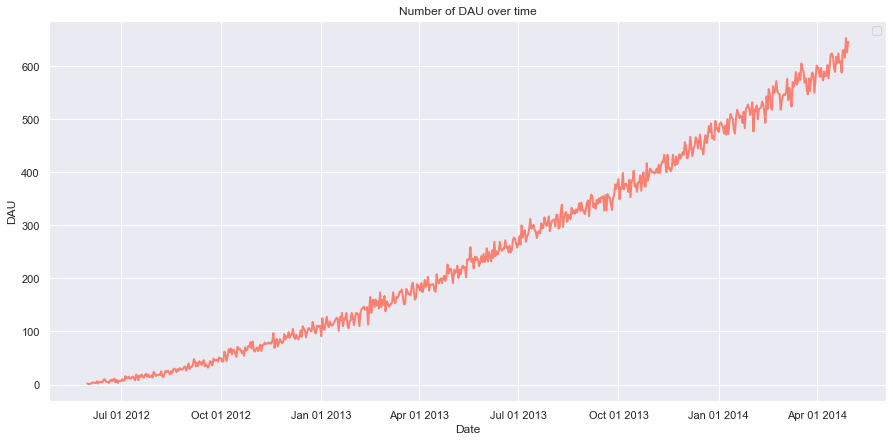

In [26]:
#make a line plot to see the trend of DAU over time
sns.set(rc={'figure.figsize':(15, 7)})

fig, ax = plt.subplots()


ax.plot(adopted_users2['visited'],linewidth=2, color= "salmon")


# Set x-ticks to yearly interval and add legend and labels
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d %Y'))
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('DAU')
ax.set_title('Number of DAU over time')

We see a significant increase in DAU over 2 years period

### b. Caculate Monthly Active Users:

In [27]:
#copy the original dataframe
adopted_users3 = adopted_users.copy()

#truncate date time data to 'month - year'
adopted_users3['time_stamp'] = pd.to_datetime(adopted_users3['time_stamp']).dt.to_period('M')
adopted_users4 = adopted_users3[['time_stamp','visited']].groupby('time_stamp').sum()

#take a quick look of first 5 row
adopted_users4.head()

,visited
time_stamp,
2012-05,2
2012-06,154
2012-07,432
2012-08,757
2012-09,1211


In [28]:
#convert periodtime datatype to datetime64
adopted_users4.index = adopted_users4.index.values.astype('datetime64[M]')
adopted_users4.index.name = 'time_stamp'

In [29]:
#prepareing data for plotting, since there were some outliers in the datetime, we will only keep the time frame that is cohorent with the analysis
adopted_users4 = adopted_users4.reset_index()
adopted_users4 = adopted_users4.loc[adopted_users4['time_stamp'] > '2012-05-01']
adopted_users4 = adopted_users4.loc[adopted_users4['time_stamp'] < '2014-05-01']
adopted_users4 = adopted_users4.set_index('time_stamp')

Text(0.5, 1.0, 'Number of MAU over time')

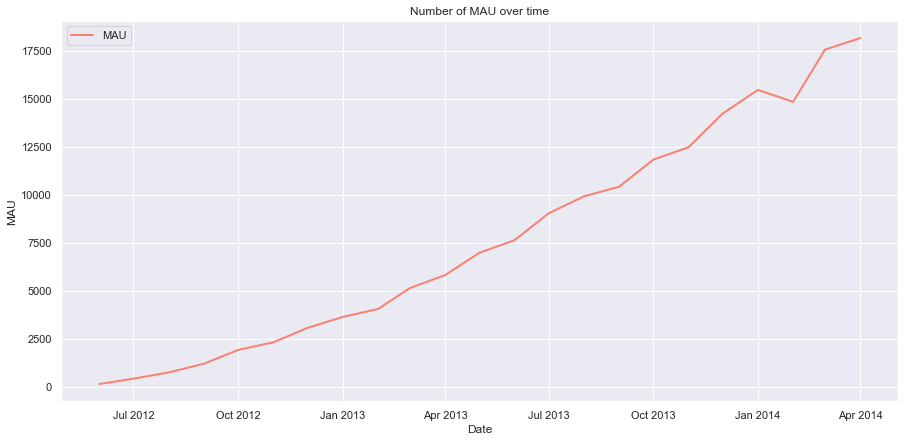

In [30]:
#make a line plot to see the trend of MAU over time
fig, ax = plt.subplots()


ax.plot(adopted_users4['visited'],linewidth=2, label='MAU', color= "salmon")


# Set x-ticks to yearly interval and add legend and labels
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('MAU')
ax.set_title('Number of MAU over time')

We see a significant increase in MAU over 2 years period

#### Let's take this a little bit further:
We want to see the MoM growth rate of adopted users to see if this is an actual increase or just relative over time based on the growth in new users

In [31]:
adopted_users_lag = adopted_users4.copy()
adopted_users_lag['lag'] = adopted_users_lag.shift(1, axis = 0) 
adopted_users_lag['MoM'] = adopted_users_lag['visited'] - adopted_users_lag['lag']
adopted_users_lag = adopted_users_lag.dropna()
adopted_users_lag.head()

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


,visited,lag,MoM
time_stamp,,,
2012-07-01,432,154.0,278.0
2012-08-01,757,432.0,325.0
2012-09-01,1211,757.0,454.0
2012-10-01,1928,1211.0,717.0
2012-11-01,2323,1928.0,395.0


Text(0.5, 1.0, 'MoM over time')

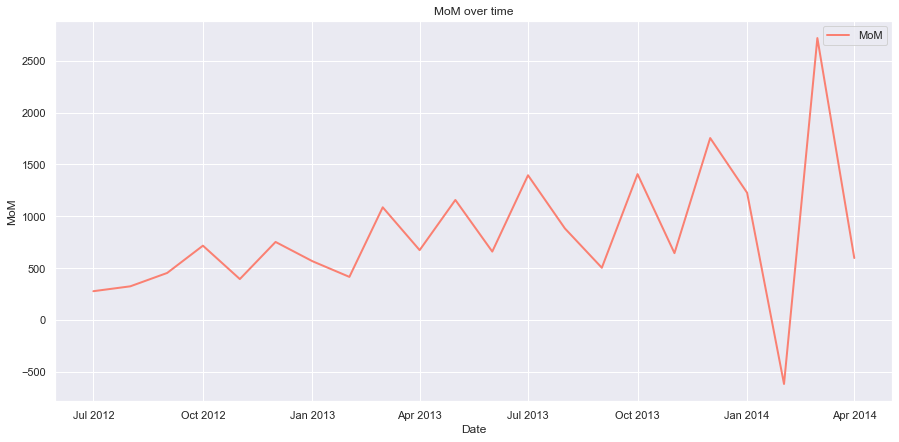

In [32]:
#make a line plot to see the MoM growth rate of adopted users
fig, ax = plt.subplots()


ax.plot(adopted_users_lag['MoM'],linewidth=2, label='MoM', color= "salmon")


# Set x-ticks to yearly interval and add legend and labels
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('MoM')
ax.set_title('MoM over time')

As we can see, the adopted user MoM growth rate is fluctuate through time, with a little increase. So the upward trend we see can be explained that it is due to the growth of new users!

### c) Calculate DAU/MAU ratio

In [33]:
#same with MAU, we will create a truncate column of 'Month - Year' in the DAU dataframe to merge the 2
adopted_users5 = adopted_users2.copy()
adopted_users5 = adopted_users5.reset_index()

adopted_users5['month'] = pd.to_datetime(adopted_users5['time_stamp']).dt.to_period('M')
adopted_users5['month'] = adopted_users5.month.values.astype('datetime64[M]')

#reset index of MAU dataframe to join
adopted_users6 = adopted_users4.copy()
adopted_users6 = adopted_users6.reset_index()

In [34]:
#join 2 dataframe by month - year column
adopted_join = adopted_users5.merge(adopted_users6, left_on='month', right_on='time_stamp',)

#take a quick look at first 5 rows
adopted_join.head()

,time_stamp_x,visited_x,month,time_stamp_y,visited_y
0,2012-06-01,1,2012-06-01,2012-06-01,154
1,2012-06-02,1,2012-06-01,2012-06-01,154
2,2012-06-03,2,2012-06-01,2012-06-01,154
3,2012-06-04,2,2012-06-01,2012-06-01,154
4,2012-06-05,4,2012-06-01,2012-06-01,154


#### The ratio of DAU to MAU is the proportion of monthly active users who engage with your product in a single day window.

In [35]:
#DAU/MAU ratio
adopted_join['DAU/MAU'] = (adopted_join['visited_x'] / adopted_join['visited_y'])*100
adopted_join.head()

#same as before, we will filter out the timeframe that have outliers
adopted_join = adopted_join.loc[adopted_join['time_stamp_y'] > '2012-05-01']
adopted_join = adopted_join.loc[adopted_join['time_stamp_y'] < '2014-05-01']


In [36]:
#prepare data for plotting

#factor out by date and DAU/MAU
adopted_join1 = adopted_join[['time_stamp_x','DAU/MAU']]

adopted_join1['time_stamp_x'] = pd.to_datetime(adopted_join1['time_stamp_x'])
adopted_join1 = adopted_join1.set_index('time_stamp_x')

adopted_join1.head()

/Users/giangnguyen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,DAU/MAU
time_stamp_x,
2012-06-01,0.649351
2012-06-02,0.649351
2012-06-03,1.298701
2012-06-04,1.298701
2012-06-05,2.597403


Text(0.5, 1.0, 'DAU/MAU ratio over time')

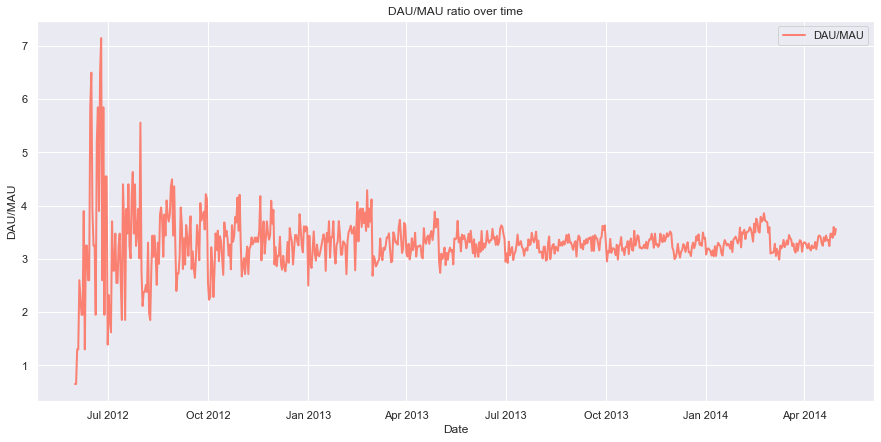

In [37]:
#make a line plot to see the trend of stickiness (DAU/MAU) over time
fig, ax = plt.subplots()

ax.plot(adopted_join1['DAU/MAU'],linewidth=2, label='DAU/MAU', color= "salmon")


# Set x-ticks to yearly interval and add legend and labels
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('DAU/MAU')
ax.set_title('DAU/MAU ratio over time')

Average of DAU/MAU ratio in 2 years:

In [38]:
adopted_join1.mean()

DAU/MAU    3.295129
dtype: float64

As we also see before in the MoM adopted user growth, the stickiness metric fluctuates through time with a little upward trend. So the high increasing rate we see before for DAU and MAU may due to the growth of new users

In [39]:
#now we will plot the count of new users each month
#copy the original dataframe
user_eng1 = user_eng.copy()

#truncate date time data to 'month - year'
user_eng1['creation_time'] = pd.to_datetime(user_eng1['creation_time']).dt.to_period('M')
user_eng1['creation_time'] = user_eng1.creation_time.values.astype('datetime64[M]')

user_eng1 = user_eng1[['creation_time','object_id']].groupby('creation_time').count()

#take a quick look of first 5 row
user_eng1.head()

,object_id
creation_time,
2012-05-01,16
2012-06-01,401
2012-07-01,387
2012-08-01,365
2012-09-01,409


Text(0.5, 1.0, 'New users over time')

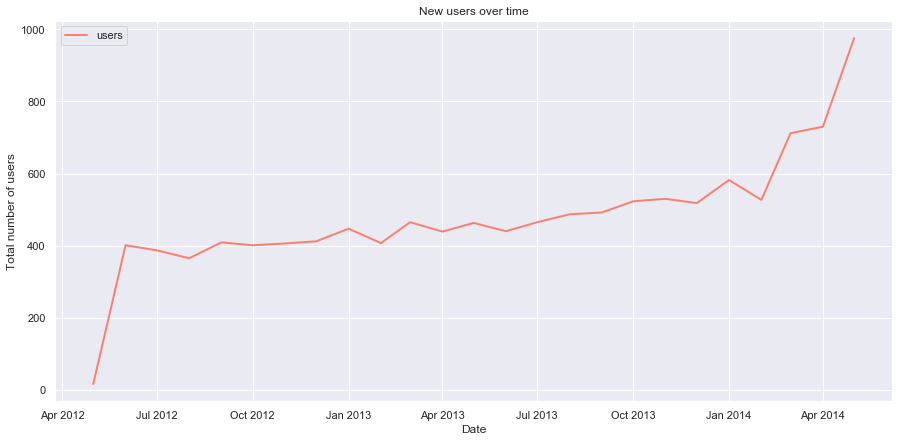

In [40]:
fig, ax = plt.subplots()

ax.plot(user_eng1['object_id'],linewidth=2, label='users', color= "salmon")


# Set x-ticks to yearly interval and add legend and labels
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Total number of users')
ax.set_title('New users over time')

Our assumption was correct, there is a huge jump of new users over the past 2 years

## 2) Best predictors for the adopted users

### a) EDA

In [41]:
# Create a dummy variable to determine if they are an adopted user or not
adopted_user_id['adopted_user'] = 1

In [42]:
# Join adopted user dataframe with original dataframe
adopted_user_join = pd.merge(adopted_user_id, user_eng, how='outer',
                  left_on='user_id', right_on='object_id')


In [43]:
#fill in non-adopted user with 0s to complete the dummies variable for adopted users
adopted_user_join['adopted_user'] = adopted_user_join['adopted_user'].fillna(0)

In [44]:
#convert unix time to utc time
adopted_user_join['last_session_creation_time'] = pd.to_datetime(adopted_user_join['last_session_creation_time'],unit='s')
adopted_user_join['last_session_creation_time'] = adopted_user_join['last_session_creation_time'].dt.tz_localize('UTC')
adopted_user_join['creation_time'] = adopted_user_join['creation_time'].dt.tz_localize('UTC')


In [45]:
# Time from account creation to last login, we name it time delta
adopted_user_join['last_active_delta'] = (adopted_user_join['last_session_creation_time'] \
                                          - adopted_user_join['creation_time']).astype('timedelta64[D]')


In [46]:
#take a quick look at first 5 rows
adopted_user_join.head()

,user_id,adopted_user,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,email_domain,last_active_delta
0,2.0,1.0,2,2013-11-15 03:45:04+00:00,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04+00:00,0,0,1,316.0,gustr.com,136.0
1,10.0,1.0,10,2013-01-16 22:08:03+00:00,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,2014-06-03 22:08:03+00:00,1,1,318,4143.0,gustr.com,503.0
2,33.0,1.0,33,2014-03-11 06:29:09+00:00,Araujo José,JoseMartinsAraujo@cuvox.de,GUEST_INVITE,2014-05-31 06:29:09+00:00,0,0,401,79.0,cuvox.de,81.0
3,42.0,1.0,42,2012-11-11 19:05:07+00:00,Pinto Giovanna,GiovannaCunhaPinto@cuvox.de,SIGNUP,2014-05-25 19:05:07+00:00,1,0,235,NaN,cuvox.de,560.0
4,50.0,1.0,50,2012-06-03 11:02:08+00:00,Oliveira Gabrielly,GabriellyAlmeidaOliveira@gmail.com,GUEST_INVITE,2012-10-23 11:02:08+00:00,0,0,61,50.0,gmail.com,142.0


In [47]:
#count value between adopted and non-adopt users
adopted_user_join['adopted_user'].value_counts()

0.0    10385
1.0     1615
Name: adopted_user, dtype: int64

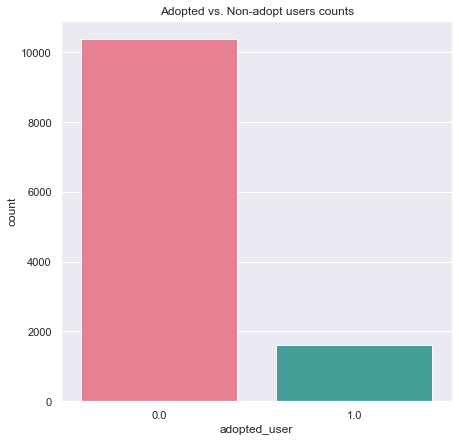

In [48]:
#plot the value counts of adopted and non-adopt users
sns.set(rc={'figure.figsize':(7, 7)})

sns.countplot(x='adopted_user',data=adopted_user_join, palette='husl')
plt.title('Adopted vs. Non-adopt users counts')
plt.show()

In [49]:
#calculate the ratio between adopt and non-adopt users

#count
count_no_adopt = len(adopted_user_join[adopted_user_join['adopted_user']==0])
count_adopt = len(adopted_user_join[adopted_user_join['adopted_user']==1])

#percentage
pct_of_no_adopt = round(count_no_adopt/(count_adopt+count_no_adopt),2)
print("percentage of no adopt is", pct_of_no_adopt*100)
pct_of_adopt = round(count_adopt/(count_adopt+count_no_adopt),2)
print("percentage of subscription", pct_of_adopt*100)

percentage of no adopt is 87.0
percentage of subscription 13.0


**We can see the problem of imbalance between 2 class of adopted and non-adopted here. So we will resample and address this later on**

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

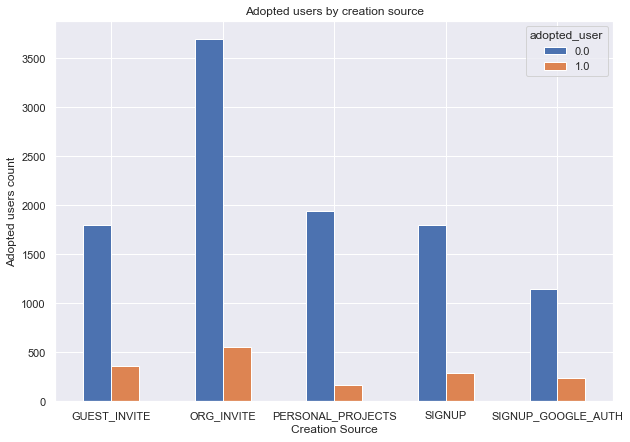

In [50]:
#draw the bar plot to compare the total count between adopted and non-adopt user segment by creation source

sns.set(rc={'figure.figsize':(10, 7)})

pd.crosstab(adopted_user_join.creation_source,adopted_user_join.adopted_user).plot(kind='bar')
plt.title('Adopted users by creation source')
plt.xlabel('Creation Source')
plt.ylabel('Adopted users count')
plt.xticks(rotation=0)

(array([0, 1]), <a list of 2 Text xticklabel objects>)

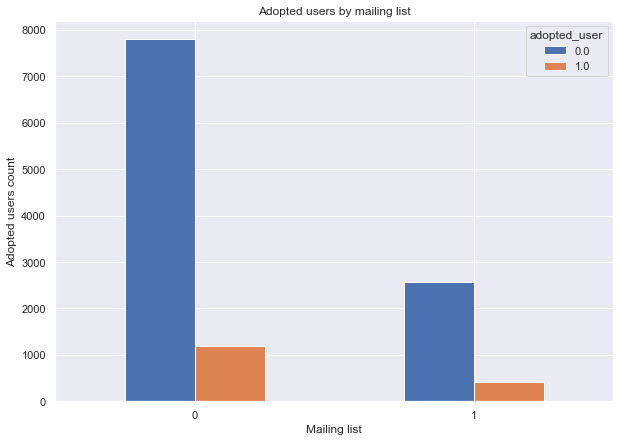

In [51]:
#draw the bar plot to compare the total count between adopted and non-adopt user segment by opt int mailing list

pd.crosstab(adopted_user_join.opted_in_to_mailing_list,adopted_user_join.adopted_user).plot(kind='bar')
plt.title('Adopted users by mailing list')
plt.xlabel('Mailing list')
plt.ylabel('Adopted users count')
plt.xticks(rotation=0)

(array([0, 1]), <a list of 2 Text xticklabel objects>)

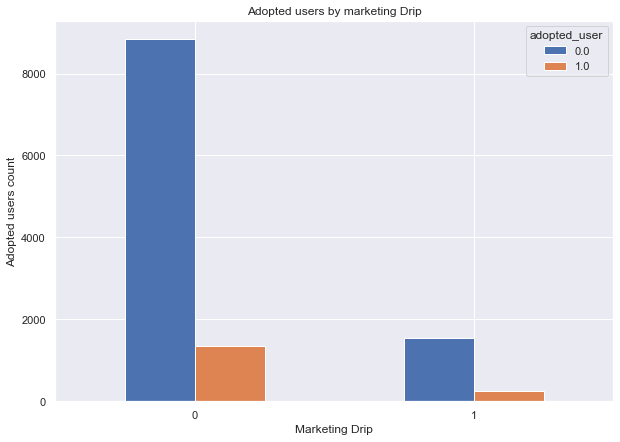

In [52]:
#draw the bar plot to compare the total count between adopted and non-adopt user segment by marketing drip
pd.crosstab(adopted_user_join.enabled_for_marketing_drip,adopted_user_join.adopted_user).plot(kind='bar')
plt.title('Adopted users by marketing Drip')
plt.xlabel('Marketing Drip')
plt.ylabel('Adopted users count')
plt.xticks(rotation=0)

In [53]:
#calculate the mean of related variables to adopted users
round(adopted_user_join.groupby('adopted_user').mean(),2)


,user_id,object_id,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,last_active_delta
adopted_user,,,,,,,
0.0,NaN,5991.12,0.25,0.15,138.63,5958.68,5.87
1.0,6060.82,6060.82,0.26,0.16,162.78,5988.44,297.35


In [54]:
#calculate the mean of numerical varibales group by creation source
round(adopted_user_join.groupby('creation_source').mean(),2)

,user_id,adopted_user,object_id,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,last_active_delta
creation_source,,,,,,,,
GUEST_INVITE,6025.32,0.17,5949.46,0.25,0.15,141.34,5912.55,74.85
ORG_INVITE,6071.94,0.13,5981.86,0.25,0.15,138.94,5988.59,55.23
PERSONAL_PROJECTS,6062.50,0.08,5975.33,0.24,0.14,144.29,NaN,67.56
SIGNUP,6022.74,0.14,6020.83,0.25,0.15,146.25,NaN,50.31
SIGNUP_GOOGLE_AUTH,6135.55,0.17,6145.20,0.24,0.15,141.52,NaN,58.12


In [55]:
#calculate the mean of numerical varibales group by mailing list subscribers or not
round(adopted_user_join.groupby('opted_in_to_mailing_list').mean(),2)

,user_id,adopted_user,object_id,enabled_for_marketing_drip,org_id,invited_by_user_id,last_active_delta
opted_in_to_mailing_list,,,,,,,
0,6080.45,0.13,6065.15,0.05,141.64,5953.72,58.75
1,6004.25,0.14,5806.02,0.45,142.62,5990.33,60.61


In [56]:
#calculate the mean of numerical varibales group by marketing drip or not
round(adopted_user_join.groupby('enabled_for_marketing_drip').mean(),2)

,user_id,adopted_user,object_id,opted_in_to_mailing_list,org_id,invited_by_user_id,last_active_delta
enabled_for_marketing_drip,,,,,,,
0,6077.97,0.13,6032.49,0.16,141.40,5957.72,58.77
1,5968.92,0.14,5818.27,0.75,144.63,5992.64,61.75


After the general EDA, we will now dummy the categorical value in creation source, and take into account other variables for our classification models to determine which variables are the best predictors for adopted users

### b) Create dummy variables


In [57]:
adopted_user_join1 = adopted_user_join[['adopted_user','creation_source',\
                                        'opted_in_to_mailing_list',\
                                        'enabled_for_marketing_drip']]


#split the unique values in 'creation source' and assign dummy values to earch
cat_vars=['creation_source']

for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(adopted_user_join1[var], prefix=var)
    adopted_user_join2=adopted_user_join1.join(cat_list)
    adopted_user_join1=adopted_user_join2
    
data_vars=adopted_user_join1.columns.values.tolist()

to_keep=[i for i in data_vars if i not in cat_vars]
adopted_user_final=adopted_user_join1[to_keep]

#print out the name of all columns that we just split from the creation source
adopted_user_final = adopted_user_final.rename(columns={"creation_source_GUEST_INVITE": "guest_invite", \
                                   "creation_source_ORG_INVITE": "org_invite",\
                         "creation_source_PERSONAL_PROJECTS": "personal_project",\
                         "creation_source_SIGNUP": "website_signup",\
                         "creation_source_SIGNUP_GOOGLE_AUTH": "google_signup" })
adopted_user_final.columns.values

array(['adopted_user', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'guest_invite', 'org_invite',
       'personal_project', 'website_signup', 'google_signup'],
      dtype=object)

### c) Over-sampling using SMOTE

As we have seen the imbalance problem before. Now we will addressing the imbalance problem between two classes of adopted users

In [58]:
#Split between explain and response variables
X = adopted_user_final.loc[:, adopted_user_final.columns != 'adopted_user']
y = adopted_user_final.loc[:, adopted_user_final.columns == 'adopted_user']

In [59]:
#resampling data
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns

os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['adopted_user'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['adopted_user']==0]))
print("Number of subscription",len(os_data_y[os_data_y['adopted_user']==1]))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['adopted_user']==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['adopted_user']==1])/len(os_data_X))

length of oversampled data is  14510
Number of no subscription in oversampled data 7255
Number of subscription 7255
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


/Users/giangnguyen/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Now our data is balance and ready for modelling.

### d) Feature Importance Selection

#### We can use XGBoost model to find features that have most important in predicting adopted users

In [60]:
#take response and explain date from balanced dataset
X=os_data_X[['opted_in_to_mailing_list',\
       'enabled_for_marketing_drip', 'guest_invite', 'org_invite',\
       'personal_project', 'website_signup', 'google_signup']]

y=os_data_y['adopted_user']

#Train test split
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X, y, test_size=0.3, random_state=0)


In [61]:
#Hyperparameter tuning for XGBoost

param_test = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

gsearch = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch.fit(X_train_xgb,y_train_xgb)

#print out the best score
gsearch.best_params_, gsearch.best_score_

({'max_depth': 3, 'min_child_weight': 1}, 0.5759193008068071)

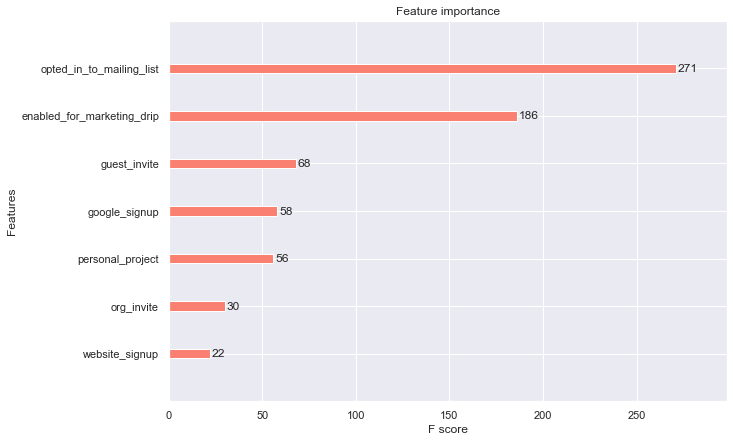

In [62]:
#using XGboost for feature importance
xgb = XGBClassifier(max_depth = 3, min_child_weight = 1)
xgb.fit(X_train_xgb, y_train_xgb)

# plot feature importance
plot_importance(xgb, color='salmon')
pyplot.show()

In [63]:
# Apply The Full Featured Classifier To The Test Data
y_pred_xgb = xgb.predict(X_test_xgb)

xgb.fit(X_train_xgb, y_train_xgb)
print("Accuracy on training set: {:.3f}".format(xgb.score(X_train_xgb, y_train_xgb)))
print("Accuracy on test set: {:.3f}".format(xgb.score(X_test_xgb, y_test_xgb)))


Accuracy on training set: 0.554
Accuracy on test set: 0.550


In [64]:
#Confusion metrics
confusion_matrix_xgb = confusion_matrix(y_test_xgb, y_pred_xgb)
print(confusion_matrix_xgb)

[[1449  731]
 [1228  945]]


This mean that we 1,449 + 945 = 2,394 correct predictions and incorrecly classify 1,228 + 731 = 1,959

#### We can also use Random Forest model to find features that have most important in predicting adopted users

In [65]:
#create labels 
predict_labels = ['opted_in_to_mailing_list',\
       'enabled_for_marketing_drip', 'guest_invite', 'org_invite',\
       'personal_project', 'website_signup', 'google_signup']

#take response and explain date from balanced dataset
X=os_data_X[['opted_in_to_mailing_list',\
       'enabled_for_marketing_drip', 'guest_invite', 'org_invite',\
       'personal_project', 'website_signup', 'google_signup']]

y=os_data_y['adopted_user']

#Train test split
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X, y, test_size=0.3, random_state=0)


#### We can use Gridsearch to find the best model for the Random Forest

In [66]:
#Generate the random grid to fit in the Gridsearch

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [67]:
# Use the random grid to search for best hyperparameters

# Create the base model to tune
rf = RandomForestRegressor()

# For random search of parameters, using 5 fold cross validation, 
# search across 150 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 150,\
                               cv = 5, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model and select the best param
rf_random.fit(X_train_rf, y_train_rf)
rf_random.best_params_

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:  7.9min finished


{'n_estimators': 200,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 40,
 'bootstrap': True}

In [68]:
#Now we find the best parameters to fit in the Random Forest model, we will use it to measure the feature important in the data

#RF model
rf = RandomForestClassifier(n_estimators= 400, min_samples_split= 10, min_samples_leaf= 4, \
                             max_features= 'sqrt', max_depth= 90, bootstrap= True)

# Train the classifier
rf.fit(X_train_rf, y_train_rf)

# Print the name and gini importance of each feature
for feature in zip(predict_labels, rf.feature_importances_):
    print(feature)


('opted_in_to_mailing_list', 0.0904263454482633)
('enabled_for_marketing_drip', 0.04841109892587863)
('guest_invite', 0.1257497658513466)
('org_invite', 0.06422640891005184)
('personal_project', 0.4416182974292355)
('website_signup', 0.0447355269069275)
('google_signup', 0.18483255652829658)


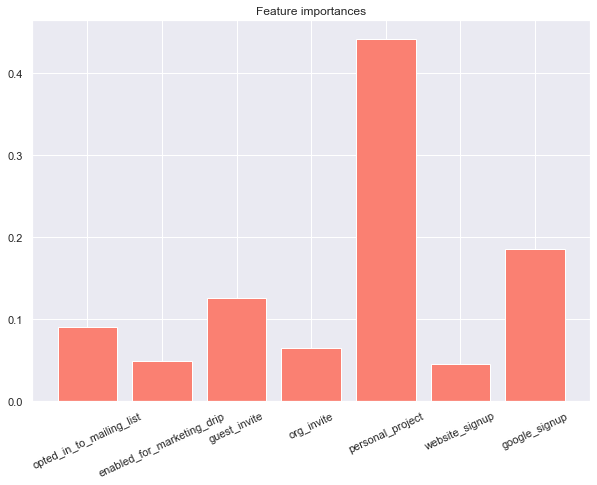

In [69]:
plt.figure()
sns.set(rc={'figure.figsize':(20, 10)})
plt.title("Feature importances")
plt.bar(predict_labels,rf.feature_importances_, align="center", color='salmon')
plt.xticks(predict_labels)
plt.xticks(rotation=25)
plt.show()

**We can see the Personal project, Guest invite and Sigup Google are the top 3 important features**

In [70]:
# Apply The Full Featured Classifier To The Test Data
y_pred_rf = rf.predict(X_test_rf)

rf.fit(X_train_rf, y_train_rf)
print("Accuracy on training set: {:.3f}".format(rf.score(X_train_rf, y_train_rf)))
print("Accuracy on test set: {:.3f}".format(rf.score(X_test_rf, y_test_rf)))


Accuracy on training set: 0.554
Accuracy on test set: 0.550


**We can see that there the accuracy score is not high since this is the model build on top of balanced dataset. Therefore, to effectively measure the accuracy of the model in this situation, we look at the confusion matrix instead**

In [71]:
#Confusion metrics
confusion_matrix_rf = confusion_matrix(y_test_rf, y_pred_rf)
print(confusion_matrix_rf)

[[1449  731]
 [1228  945]]


This mean that we 1,449 + 945 = 2,394 correct predictions and incorrecly classify 1,228 + 731 = 1,959

#### Conclusion for feature important:

Since we see the important features differ for XGBoost and Random Forest given the same accuracy, these are potential reasons:

- When there are several correlated features, XGBoost will tend to choose one and use it in several trees so other correlated features won t be used a lot (or probably not at all). Therefore, other correlated features can't help in the split process anymore, and they don't bring new information regarding the already used feature. 

- On the other hand, each tree of a Random forest is not built from the same features since there is a random selection of features to use for each tree. Hence, each correlated feature may have the chance to be selected in one of the tree. Therefore, the learning is done in parallel so each tree is not aware of what have been used for other trees.

We are going to **test the correlation** between variables choosing the right model for feature importance:

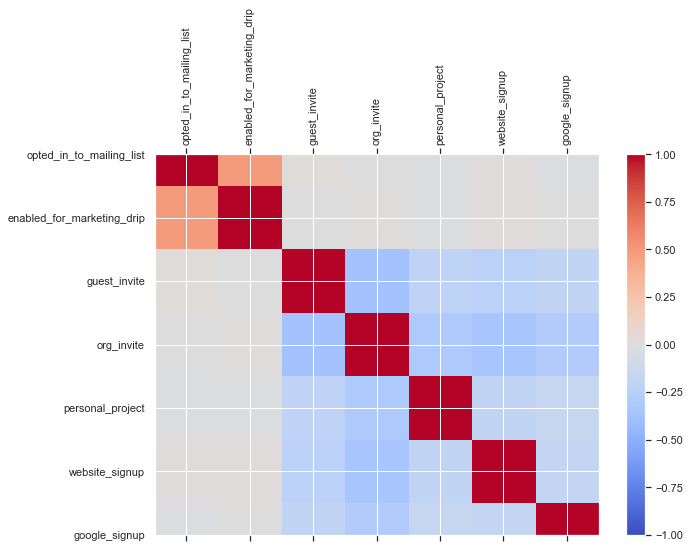

In [72]:
#correlation for variables in X
corr = X.corr()
sns.set(rc={'figure.figsize':(10, 7)})

#Plot the correlation
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(X.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(X.columns)
ax.set_yticklabels(X.columns)
plt.show()

We can see that these variables are highly correlated with each other in different ways, therefore, we will go with Random Forest as a more unbiased and precise decision in this case.

### e) Logistic Regression: analyse the significance of each variables on adopted users

We can take a brief look at Last active time delta to see if this variable is correlated to user adoption

In [73]:
# implement the model
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.683473
         Iterations 4
                              Results: Logit
Model:                  Logit               Pseudo R-squared:    0.014     
Dependent Variable:     adopted_user        AIC:                 19848.3954
Date:                   2020-01-10 12:46    BIC:                 19901.4736
No. Observations:       14510               Log-Likelihood:      -9917.2   
Df Model:               6                   LL-Null:             -10058.   
Df Residuals:           14503               LLR p-value:         1.0932e-57
Converged:              1.0000              Scale:               1.0000    
No. Iterations:         4.0000                                             
---------------------------------------------------------------------------
                            Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------------
opted_in_to_maili

According to the p-value and coefficients:
- Since the p-value of Guest_invite, Personal_Projects and Google signup are smaller than 0.05 significant level, we will take these values in our classification model as they are statistically significant. Org_invite seems to have small effect since the p-value is approximately 0.05, we can also take into acount this variables for our model this time

- From the coefficients, we can see that by having one 1 additional in Guest_invite, we will have 25% increase in the odd of adopted users since $e^{0.227}$ = 1.25, while it is 42% for Google signup as $e^{0.354}$ = 1.42. 

- On the other had, it's pretty counterintuitive that Org_invite and Personal projects have negative coefs, which means that they have negative effect on the odd of adopted users. In particular, an increase in 1 org_invite will decrease the odd of adopted users by 6% ($e^{0.0581}$ = 1.059). Likewise, 1 additional Personal_project signup will decrease the odd of adopted user by 81% ($e^{0.5935}$ = 1.81)

In [74]:
# Since there are only Guest_invite, Personal_Projects, Google signup, Org_invite are significant, we will only include them in our model

X = X[['guest_invite', 'org_invite','personal_project', 'website_signup', 'google_signup']]
y = y

#train test split
X_train_logit, X_test_logit, y_train_logit, y_test_logit = train_test_split(X, y, test_size=0.3, random_state=0)


#### Similaryly, we can use Gridsearch to find the best hyperparameter for the Logistic Regression

In [75]:
#generate random grid with l2 penalty
grid={"C":np.logspace(0.01,0.001,10,100,1000), "penalty":["l2"]}# l2 ridge
logreg=LogisticRegression(solver='lbfgs')
logreg_cv=GridSearchCV(logreg,grid,cv=5)
logreg_cv.fit(X_train_logit,y_train_logit)

#choosing the best parameters
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)


tuned hpyerparameters :(best parameters)  {'C': 1.0715193052376064, 'penalty': 'l2'}
accuracy : 0.5449443733385843


In [76]:
# train the model
logreg1 = LogisticRegression(C=1.07)
logreg1.fit(X_train_logit, y_train_logit)


/Users/giangnguyen/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.07, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [77]:
y_pred_logit = logreg1.predict(X_test_logit)


logreg1.fit(X_train_logit, y_train_logit)
print("Accuracy on training set: {:.3f}".format(logreg1.score(X_train_logit, y_train_logit)))
print("Accuracy on test set: {:.3f}".format(logreg1.score(X_test_logit, y_test_logit)))


Accuracy on training set: 0.548
Accuracy on test set: 0.545


/Users/giangnguyen/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


**We can see that there the accuracy score is not high since this is the model build on top of balanced dataset. Therefore, to effectively measure the accuracy of the model in this situation, we look at the confusion matrix instead**

In [78]:
#Confusion metrics
confusion_matrix_logit = confusion_matrix(y_test_logit, y_pred_logit)
print(confusion_matrix_logit)


[[1561  619]
 [1361  812]]


This mean that we correctly classify 1,561 + 812 = 2,373 and incorrecly classify 1172 + 796 = 1,980

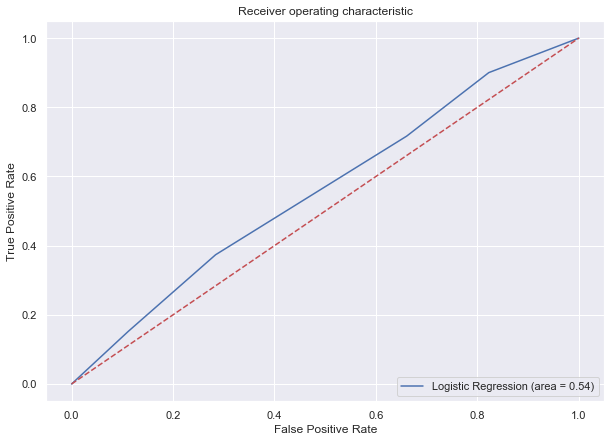

In [79]:

logit_roc_auc = roc_auc_score(y_test_logit, logreg1.predict(X_test_logit))
fpr, tpr, thresholds = roc_curve(y_test_logit, logreg1.predict_proba(X_test_logit)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

This indicates that we did a fair job in our model

### f) Logistic Regression for last active time delta:

We will now do a separate model for the time delta to see the significance of this variable on adopted user

In [80]:
#preprocessing the data
adopted_user_join1 = adopted_user_join.dropna(subset=['last_active_delta'])
X_delta = adopted_user_join1[['last_active_delta']]
y_delta = adopted_user_join1[['adopted_user']]

#train split test
X_train_delta, X_test_delta, y_train_delta, y_test_delta = train_test_split(X_delta, y_delta, test_size=0.3, random_state=0)


In [81]:
logit_model=sm.Logit(y_delta,X_delta)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.622126
         Iterations 7
                         Results: Logit
Model:              Logit            Pseudo R-squared: -0.307    
Dependent Variable: adopted_user     AIC:              10980.0417
Date:               2020-01-10 12:46 BIC:              10987.1269
No. Observations:   8823             Log-Likelihood:   -5489.0   
Df Model:           0                LL-Null:          -4199.6   
Df Residuals:       8822             LLR p-value:      nan       
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
-----------------------------------------------------------------
                     Coef.  Std.Err.    z    P>|z|  [0.025 0.975]
-----------------------------------------------------------------
last_active_delta    0.0093   0.0005 20.6497 0.0000 0.0084 0.0102



According to the p-value and coefficients:
- Since the p-value of last_active_delta is smaller than 0.05 significant level, we can consider that this variable is statistically significance.

- From the coefficients, we can see that by having one 1 additional last_active_delta will yield increase in the odd of adopted users by 0.93% since $e^{0.0093}$ = 1.0093

- This is pretty intuitive as the longer a user stay active on the platform, they will be more likely to be adopted.

In [82]:
# train the model
logreg1.fit(X_train_delta, y_train_delta)

/Users/giangnguyen/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/giangnguyen/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.07, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [83]:
y_pred_delta = logreg1.predict(X_test_delta)


logreg1.fit(X_train_delta, y_train_delta)
print("Accuracy on training set: {:.3f}".format(logreg1.score(X_train_delta, y_train_delta)))
print("Accuracy on test set: {:.3f}".format(logreg1.score(X_test_delta, y_test_delta)))


Accuracy on training set: 0.962
Accuracy on test set: 0.962


/Users/giangnguyen/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/giangnguyen/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [84]:
confusion_matrix_delta = confusion_matrix(y_test_delta, y_pred_delta)
print(confusion_matrix_delta)

[[2130   33]
 [  67  417]]


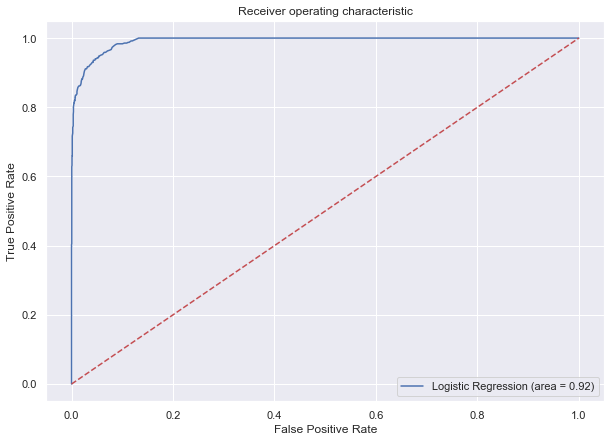

In [85]:

logit_roc_auc = roc_auc_score(y_test_delta, logreg1.predict(X_test_delta))
fpr, tpr, thresholds = roc_curve(y_test_delta, logreg1.predict_proba(X_test_delta)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

Our model did a good job at the model with 96.2% accuracy for the test set.

Reference: 
- https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
- https://chrisalbon.com/machine_learning/trees_and_forests/feature_selection_using_random_forest/

## Recommendations

- Investigate user journey for each demographic (Guest vs Full Member) to detect drop-off points and troubleshoot.
- Optimize the on-boarding experience that is tailored for different demographics.
 - Especially, for Personal Project sign-ups , we can prompt these users to create their own project so they will continue to use Asana even after finishing working on other's project.
 - Encourage Full Member to explore other premium features on Asana other than their cross-team projects so they can create their own documentation/plans for their individual or team work.
- As the likelihood of adopted users for Google sign-ups are the highest, we should expand this fast and seamless sign-up experience more by partnering with Facebook, Linkedin, Outlook, etc. to accelerate more sign-up growth rate and user adoption.
- Emails are not effective at improving user adoption, so we need to extend the analysis on other messaging platforms to test which other communication channels can do a better job at engaging users (push, in-app messaging, etc.)
- Since the high growth rate in 2014 greatly impact the user engagement and adoption, we can expand the analysis to find key success indicators on user actions or product features that best pivot growth and adoption rate during 2014.
- Regarding further exploration, I am keen on exploring (1) Does the size of members in an organization affect adoption rate? (2) Which actions do a team or an individual took that best indicate adoption rate?